<a href="https://colab.research.google.com/github/adedert/hf_bachelor/blob/main/hf_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for BERT word embedding

In [55]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

# Define tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

# Function to get index of word we want embedding for
def get_word_idx(sentence: str, word: str):
    try:
        return sentence.lower().split(" ").index(word.lower())
    except ValueError:
        print(f"The word '{word}' is not found in the sentence: {sentence}")
        return -1  # Return -1 if word is not found

def get_hidden_states(encoded, token_ids_word, layer):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
      Select only those subword token outputs that belong to our word of interest
      and average them."""
    # Send token IDs through the model to get output
    with torch.no_grad():
        output = model(**encoded)
    # Embedding of only one state
    hidden_state = output.hidden_states[layer].squeeze()
    #print(f"hidden_state: {hidden_state.size()}")
    # Only select the tokens that build the requested word
    word_tokens_output = hidden_state[token_ids_word]

    return word_tokens_output  # Get vector of outputs for specific word

def get_word_vector(sentence, idx, layer):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
      that make up the word of interest, and then `get_hidden_states`."""
    # Encode token idxs or word idxs from words
    encoded = tokenizer.encode_plus(sentence, return_tensors="pt")

    # Get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)

    return get_hidden_states(encoded, token_ids_word, layer)  # Encode word and pass it through get_hidden_states

def word_embedding(sentence: str, word: str, layer: int):
    # Index of target word
    idx = get_word_idx(sentence, word)
    if idx == -1:
        return None

    word_embedding = get_word_vector(sentence, idx, layer)

    return word_embedding


In [56]:
#embed_1 = word_embedding("He fishes on the river bank", "bank", 1)

In [57]:
# Dimension reduction from 768 to 2 dimensions
dim_reducer = TSNE(n_components=2, perplexity=1)

def visualize_layerwise_embeddings(layers_to_visualize, sentences: list, word: str, labels):
    num_layers = len(layers_to_visualize)
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(6*num_layers, 6))

    labels = np.array(labels)
    labels = labels.reshape(-1)


    for i, layer_i in enumerate(layers_to_visualize):
        word_embed_list = []
        for sentence in sentences:
            word_embed = word_embedding(sentence, word, layer_i)
            if word_embed is not None:
                word_embed_list.append(word_embed)

        if not word_embed_list:
            print(f"No valid embeddings found for the word '{word}' in layer {layer_i}")
            continue
        print(f"word embed list: {len(word_embed_list)}")
        word_embed_array = np.concatenate(word_embed_list, axis=0)
        print(f"word embed array: {len(word_embed_array)}")

        layer_dim_reduced_embeds = dim_reducer.fit_transform(word_embed_array)

        print(f"labels:{len(labels)}")
        print(f"layer dim reduced: {len(layer_dim_reduced_embeds[:,0])}")
        df = pd.DataFrame({'x': layer_dim_reduced_embeds[:, 0], 'y': layer_dim_reduced_embeds[:, 1],'label':labels})
        # Calculate subplot indices
        row_idx = i // 4
        col_idx = i % 4

        sns.scatterplot(data=df, x='x', y='y', hue='label', ax=ax[row_idx, col_idx])
        ax[row_idx, col_idx].set_title(f'Layer {layer_i}')

    plt.show()

In [58]:
data_bank = [
    "Ducks waddle along the river bank",
    "Picnic by the shady bank under trees",
    "Kids skip stones at the river bank",
    "Tress shade the calm river bank",
    "Fishing rods rest against the bank",
    "Frogs croak by the muddy bank",
    "Sunrise paints hues on the river bank",
    "Couples stroll along the river bank",
    "Canoeists navigate down the winding bank",
    "Otters playfully slide into the river bank",
    "Wildflowers bloom on the grassy bank",
    "A heron hunts patiently by the bank",
    "Fishermen cast lines from the bank",
    "River bank erosion threatens nearby homes",
    "Kayaks launch from the sandy bank",
    "Birds nestle in reeds by the bank",
    "River bank trees reflect in the water",
    "Rapids crash against the rocky bank",
    "Sunsets bathe the river bank in gold",
    "Children build sandcastles on the bank",
    "Campers pitch tents near the river bank",
    "Deer cautiously approach the river bank",
    "Hikers rest on boulders by the bank",
    "Rafters disembark onto the muddy bank",
    "Turtles bask in sunlight on the bank",
    "Logs drift lazily along the river bank",
    "Grasshoppers chirp in the river bank grass",
    "Herbs grow abundantly along the bank",
    "Rowboats gently bob by the quiet bank",
    "Fishermen haul nets onto the bank",
    "Marsh marigolds bloom by the bank",
    "Squirrels scurry up trees on the bank",
    "Dragonflies dart above the river bank",
    "An old bridge spans the river bank",
    "The moonlight dances on the river bank",
    "Ripples lap against the pebbled bank",
    "Swans glide gracefully along the bank",
    "Fallen leaves gather along the river bank",
    "The river curves gently by the bank",
    "Beaver dams alter the flow near the bank",
    "Bicyclists pedal along the paved bank",
    "Canopies of leaves shade the river bank",
    "Fishermen swap tales at the bank",
    "Dandelions dot the grassy river bank",
    "Carp leap out of the water near the bank",
    "Leeches lurk in the shallows by the bank",
    "A footbridge spans the narrow river bank",
    "River otters frolic in the shallow bank",
    "Muskrats burrow into the muddy bank",
    "Cattails sway in the breeze by the bank",
    "My bank account balance is higher than expected",
    "The bank branch is conveniently located near my workplace",
    "I'm worried about the security of my bank account",
    "Opening a savings account at the bank was easy",
    "She's meeting with the bank to discuss investment options",
    "I'm transferring money between bank accounts for better interest rates",
    "The bank manager called to discuss a potential loan application",
    "We're considering switching bank due to poor customer service",
    "My bank statement arrived earlier than usual this month",
    "He's applying for a mortgage through the bank online portal",
    "I need to update my address on file with the bank",
    "She's discussing retirement planning with a bank advisor",
    "The bank teller greeted me with a warm smile",
    "I'm visiting the bank to inquire about personal loans",
    "He's exploring different bank for business financing options",
    "I'm worried about the economic stability of the bank",
    "She's researching online banking options offered by the bank",
    "My bank offers overdraft protection for a small fee",
    "I'm concerned about the potential for bank fraud",
    "He's meeting with a financial advisor at the bank headquarters",
    "I'm considering consolidating my debts through the bank",
    "She's exploring investment opportunities outside of traditional bank",
    "My bank offers incentives for referring friends to their services",
    "I'm setting up a recurring payment through my bank website",
    "He's applying for a credit card through the bank mobile app",
    "I'm considering investing in stocks through my bank brokerage",
    "She's monitoring her spending habits using the bank budgeting tools",
    "I'm looking into refinancing my car loan with the bank",
    "He's reviewing his retirement savings plan with a bank consultant",
    "I'm receiving alerts for suspicious activity on my bank account",
    "She's discussing estate planning with a bank wealth manager",
    "I'm setting up direct deposit for my paycheck with the bank",
    "He's discussing student loan options with a bank representative",
    "I'm using the bank online calculator to estimate mortgage payments",
    "She's researching the benefits of opening a trust account with the bank",
    "I'm meeting with a bank officer to resolve a billing issue",
    "He's considering opening a business account with the bank",
    "I'm reviewing the terms and conditions of my bank account",
    "She's discussing tax planning strategies with a bank advisor",
    "I'm exploring the possibility of investing in mutual funds through the bank",
    "He's applying for a small business loan with the bank assistance",
    "I'm contacting the bank customer service department to report a lost card",
    "She's considering setting up a retirement savings plan with the bank",
    "I'm discussing my financial goals with a bank relationship manager",
    "He's comparing interest rates for savings accounts offered by different bank",
    "I'm updating my beneficiaries for my bank accounts",
    "She's requesting a credit limit increase from the bank",
    "I'm scheduling an appointment with a bank advisor for investment advice",
    "He's applying for a home equity line of credit through the bank"
]

labels_0 = [0] * 50

labels_1 = [1] * 50



word embed list: 8
word embed array: 8
labels:8
layer dim reduced: 8
word embed list: 8
word embed array: 8
labels:8
layer dim reduced: 8
word embed list: 8
word embed array: 8
labels:8
layer dim reduced: 8
word embed list: 8
word embed array: 8
labels:8
layer dim reduced: 8
word embed list: 8
word embed array: 8
labels:8
layer dim reduced: 8
word embed list: 8
word embed array: 8
labels:8
layer dim reduced: 8
word embed list: 8
word embed array: 8
labels:8
layer dim reduced: 8
word embed list: 8
word embed array: 8
labels:8
layer dim reduced: 8


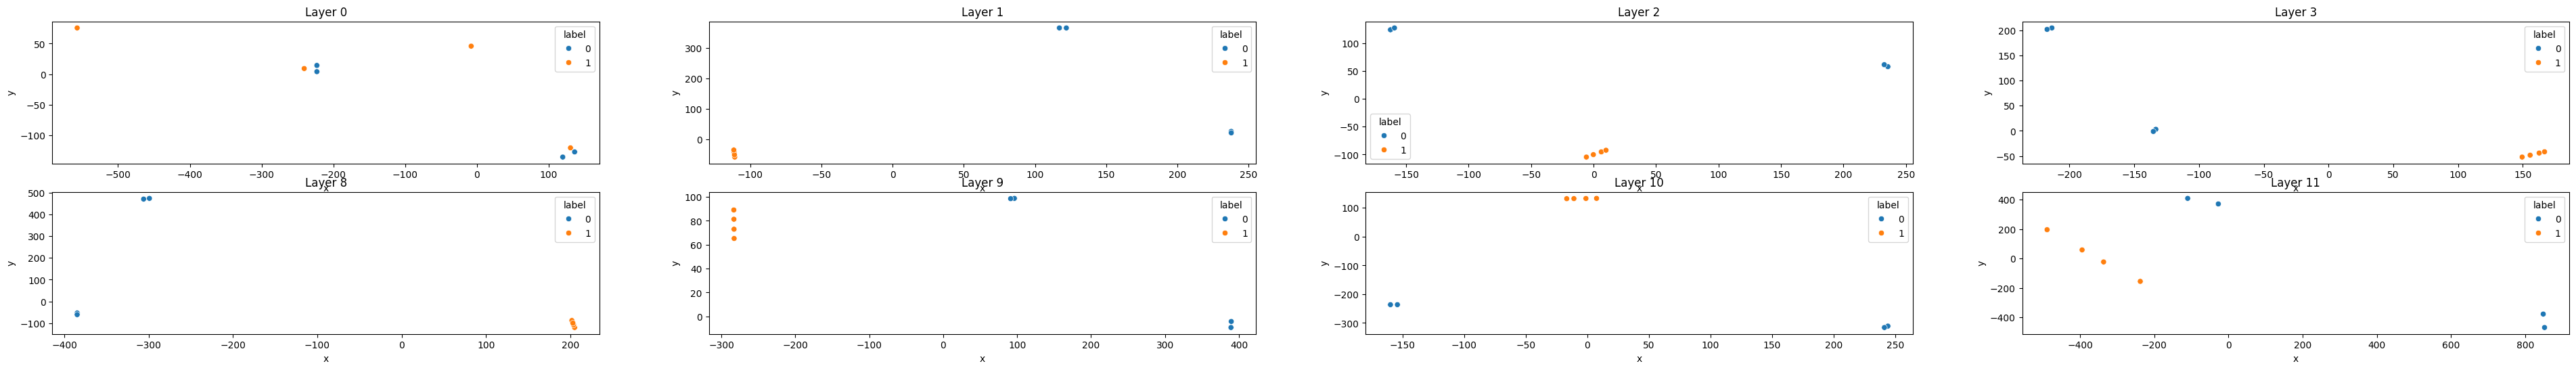

In [59]:
labels = [0,0,0,0,1,1,1,1]

sentences = ["There was an old man fishing on the bank .",
              "A house on the bank of River Severn .",
              "He jumped in and swam to the opposite bank .",
              "It is on the north bank of the Thames .",
              "My salary is directly paid into my bank .",
              "The bank issues both credit and debit cards .",
              "The company applied to the bank for a loan .",
              "She closed her account at the bank and turned in her resignation ."
             ]

labels_b = labels_0 + labels_1

visualize_layerwise_embeddings(layers_to_visualize=[0, 1, 2, 3, 8, 9, 10, 11],
                               sentences=sentences,
                               word="bank",
                               labels=labels)